In [ ]:
import pandas as pd  # Import pandas for data manipulation and analysis
import numpy as np  # Import numpy for numerical operations and handling arrays
import matplotlib.pyplot as plt  # Import matplotlib for data visualization
import pandas_datareader as data  # Import datareader to fetch financial data from online sources

from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler to normalize data between 0 and 1
from keras.layers import Dense, Dropout, LSTM  # Import neural network layers: Dense (output), Dropout (regularization), and LSTM (recurrent layer for time series)
from keras.models import Sequential  # Import Sequential model to build a linear stack of layers


In [ ]:
plt.style.use("fivethirtyeight")  # Apply the 'fivethirtyeight' style to make plots visually appealing (mimics FiveThirtyEight's design)

%matplotlib inline  # Jupyter-specific magic command to display plots directly below code cells
#It sets a clean, professional plot style and ensures that all visualizations show up inline when you're working in a Jupyter Notebook.



In [ ]:
import yfinance as yf  # Import yfinance to download historical stock data from Yahoo Finance
import datetime as dt  # Import datetime to work with date objects

stock = "POWERGRID.NS"  # Define the stock ticker symbol for Power Grid Corporation (NSE)
start = dt.datetime(2000, 1, 1)  # Set the start date for fetching data (January 1, 2000)
end = dt.datetime(2024, 11, 1)  # Set the end date for fetching data (November 1, 2024)

df = yf.download(stock, start, end)  # Download historical stock price data from Yahoo Finance into a DataFrame
#This block pulls 24 years of historical stock data for "POWERGRID.NS" from Yahoo Finance,
# which will later be used for time series analysis and prediction using LSTM.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price             Close         High          Low         Open       Volume
Ticker     POWERGRID.NS POWERGRID.NS POWERGRID.NS POWERGRID.NS POWERGRID.NS
Date                                                                       
2007-10-05    32.545422    35.424689    26.900117    29.051480    855215656
2007-10-08    30.879332    33.645369    30.685223    33.645369    126671715
2007-10-09    32.982174    33.273335    29.229421    30.895512    116725709
2007-10-10    33.289513    33.968891    32.998352    33.839485     67931378
2007-10-11    37.009907    38.821581    32.998345    38.821581    106320954

In [ ]:
df.shape

(4208, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4208 entries, 2007-10-05 to 2024-10-31
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   (Close, POWERGRID.NS)   4208 non-null   float64
 1   (High, POWERGRID.NS)    4208 non-null   float64
 2   (Low, POWERGRID.NS)     4208 non-null   float64
 3   (Open, POWERGRID.NS)    4208 non-null   float64
 4   (Volume, POWERGRID.NS)  4208 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 197.2 KB


In [ ]:
df.isnull().sum()

Price   Ticker      
Close   POWERGRID.NS    0
High    POWERGRID.NS    0
Low     POWERGRID.NS    0
Open    POWERGRID.NS    0
Volume  POWERGRID.NS    0
dtype: int64

In [ ]:
df.describe()

Price         Close         High          Low         Open        Volume
Ticker POWERGRID.NS POWERGRID.NS POWERGRID.NS POWERGRID.NS  POWERGRID.NS
count   4208.000000  4208.000000  4208.000000  4208.000000  4.208000e+03
mean      79.483549    80.517027    78.462750    79.520589  1.188963e+07
std       63.570576    64.313382    62.779670    63.552224  2.061999e+07
min       19.001732    20.312196    17.036036    20.213911  0.000000e+00
25%       36.529119    37.105433    35.989650    36.566542  4.799653e+06
50%       55.504942    56.145821    54.762119    55.611513  8.344398e+06
75%       83.112999    84.105068    82.127454    83.135594  1.362032e+07
max      356.113861   356.893408   348.074624   354.749603  8.552157e+08

In [ ]:
df = df.reset_index()  # Reset the DataFrame index to make the 'Date' column a regular column instead of an index
#It prepares the DataFrame for easier manipulation, especially when selecting or plotting columns like 'Date' ‚Äî which is important for time series modeling and visualization.

In [ ]:
df.columns

MultiIndex([(  'Date',             ''),
            ( 'Close', 'POWERGRID.NS'),
            (  'High', 'POWERGRID.NS'),
            (   'Low', 'POWERGRID.NS'),
            (  'Open', 'POWERGRID.NS'),
            ('Volume', 'POWERGRID.NS')],
           names=['Price', 'Ticker'])

In [ ]:
data01 = pd.read_csv("powergrid.csv")  # Load the stock data from a CSV file named 'powergrid.csv' into a new DataFrame
#Instead of using data from Yahoo Finance, this line loads local data from a CSV file ‚Äî which might be a cleaned or previously saved version of the stock dataset.

In [ ]:
data01=pd.read_csv("powergrid.csv")

In [ ]:
data01.head()

Price        Date               Close                High  \
0  Ticker         NaN        POWERGRID.NS        POWERGRID.NS   
1       0  2007-10-05    32.5454216003418    35.4246891776911   
2       1  2007-10-08  30.879331588745117  33.645368840548784   
3       2  2007-10-09  32.982173919677734  33.273334876563496   
4       3  2007-10-10  33.289512634277344  33.968891159536575   

                  Low                Open        Volume  
0        POWERGRID.NS        POWERGRID.NS  POWERGRID.NS  
1   26.90011689528922  29.051480080819935     855215656  
2  30.685222864632642  33.645368840548784     126671715  
3  29.229420508905978   30.89551235079529     116725709  
4  32.998351662859996  33.839484576934595      67931378

In [ ]:
#Candelsticks
import plotly.graph_objects as go  # Import Plotly for interactive visualizations and charts

fig = go.Figure(data=[go.Candlestick(  # Create a candlestick chart
    x=data01['Date'],  # X-axis: Date (time series)
    open=data01['Open'],  # Opening price for each period
    high=data01['High'],  # Highest price of the period
    low=data01['Low'],    # Lowest price of the period
    close=data01['Close']  # Closing price for each period
)])

fig.update_layout(xaxis_rangeslider_visible=False)  # Hide the range slider at the bottom of the plot for a cleaner look

fig.show()  # Display the interactive candlestick chart


In [ ]:
df=df.drop(["Date"], axis=1)

<ipython-input-15-daa1d7a4afde>:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [ ]:
df.head(2)

Price         Close         High          Low         Open       Volume
Ticker POWERGRID.NS POWERGRID.NS POWERGRID.NS POWERGRID.NS POWERGRID.NS
0         32.545422    35.424689    26.900117    29.051480    855215656
1         30.879332    33.645369    30.685223    33.645369    126671715

<function matplotlib.pyplot.show(close=None, block=None)>

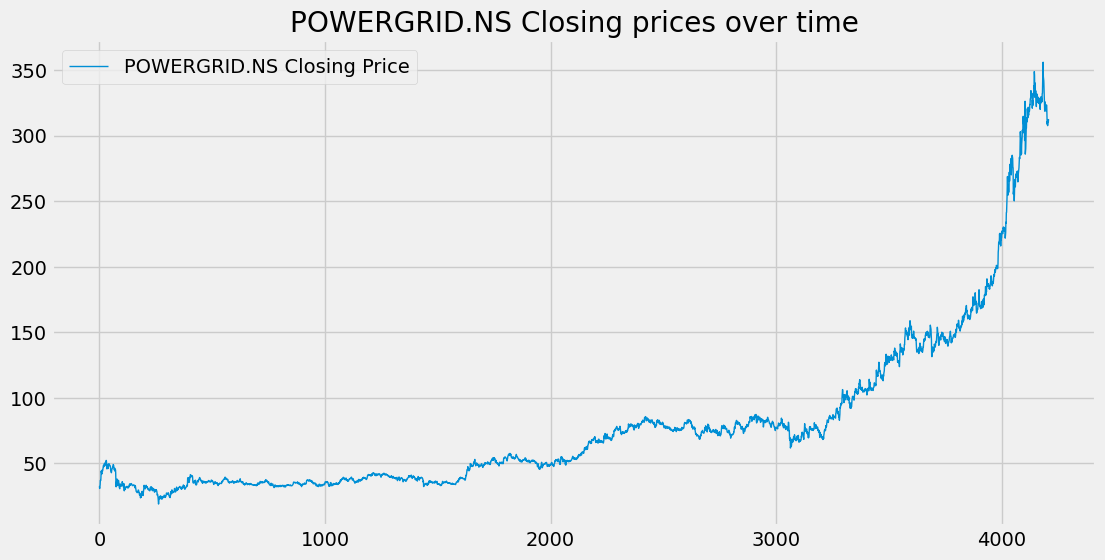

In [ ]:
plt.figure(figsize=(12, 6))  # Set the figure size to 12x6 inches for better readability of the plot

plt.plot(df['Close'], label=f'{stock} Closing Price', linewidth=1)  # Plot the 'Close' column from the DataFrame with a line width of 1

plt.title(f'{stock} Closing prices over time')  # Set the title of the plot to show the stock's name and closing prices

plt.legend()  # Display the legend to label the line as the 'Closing Price'

plt.show()  # Display the plot


<function matplotlib.pyplot.show(close=None, block=None)>

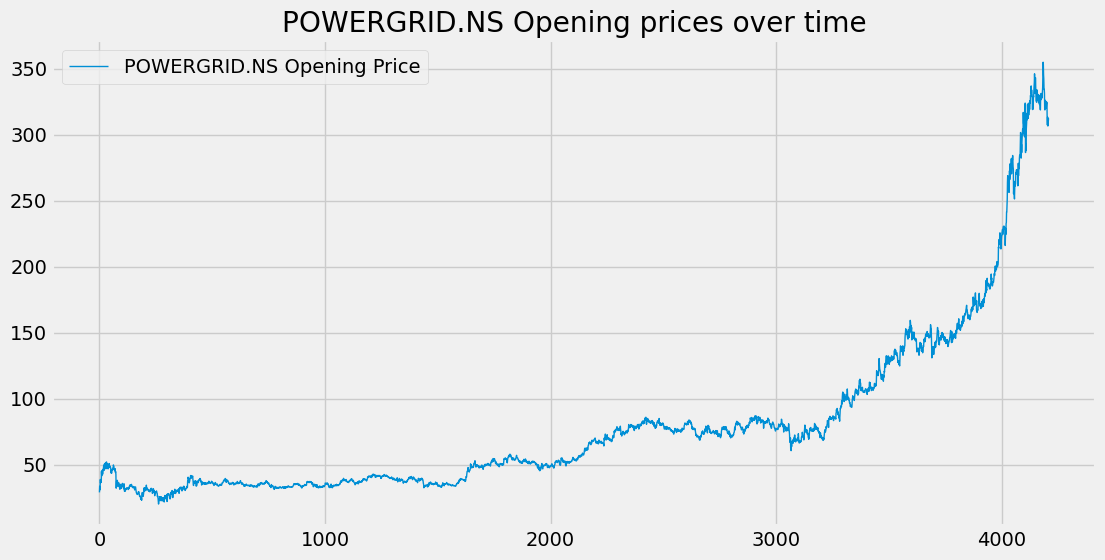

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Open'], label = f'{stock} Opening Price', linewidth = 1)
plt.title(f'{stock} Opening prices over time')
plt.legend( )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

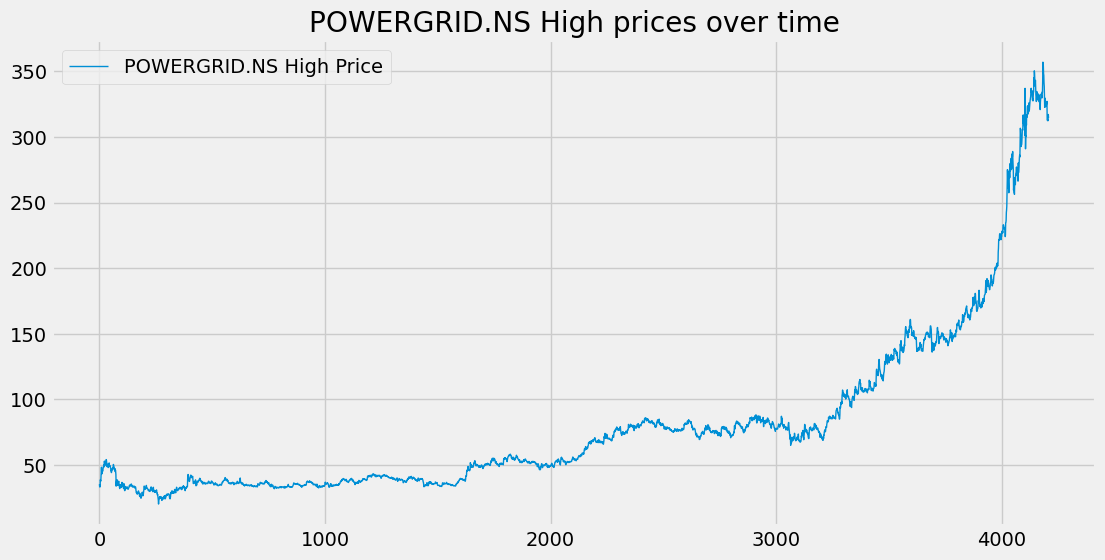

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['High'], label = f'{stock} High Price', linewidth = 1)
plt.title(f'{stock} High prices over time')
plt.legend( )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

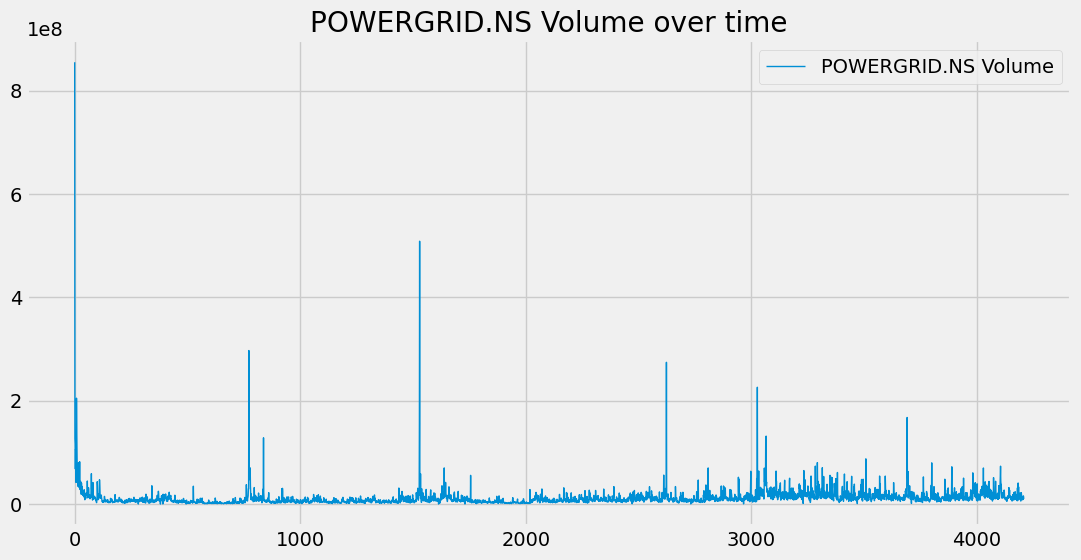

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Volume'], label = f'{stock} Volume', linewidth = 1)
plt.title(f'{stock} Volume over time')
plt.legend( )
plt.show

In [ ]:
#Moving average
temp_data= [10, 20, 30, 40, 50, 60, 70, 80, 90]
print(sum(temp_data[2:7])/5)


50.0



A moving average is a statistical method used to smooth out short-term fluctuations and highlight longer-term trends or cycles in data.

It‚Äôs commonly used in time series analysis (like stock prices, sales data, weather trends, etc.).

 Types of Moving Averages
 Simple Moving Average (SMA) ‚Äì Takes the arithmetic mean of the last n values.

Exponential Moving Average (EMA) ‚Äì Gives more weight to recent observations.
Now, calculate a 3-day moving average:

For Day 3: (100 + 120 + 130) / 3 = 116.67

For Day 4: (120 + 130 + 90) / 3 = 113.33

For Day 5: (130 + 90 + 150) / 3 = 123.33


Exponential Moving Average (EMA) is a type of moving average that places a greater weight and significance on the most recent data points.
 FORMULA FOR EMA:
       EMA_today = (Value_today √ó K) + (EMA_yesterday √ó (1 ‚àí K))

Where:

K = 2 / (n + 1)

n = number of periods (e.g., 3-day EMA)

EMA_yesterday = previous day‚Äôs EMA (for the first value, we often start with SMA)


SMA of first 3 days = (100 + 120 + 130) / 3 = 116.67

This becomes EMA for Day 3


Apply EMA formula from Day 4 onwards
EMA=(90√ó0.5)+(116.67√ó0.5)=45+58.34=‚àó‚àó103.34‚àó‚àó
EMA=(150√ó0.5)+(103.34√ó0.5)=75+51.67=‚àó‚àó126.67‚àó‚àó

In [ ]:
df01 = pd.DataFrame(temp_data)  # Convert the 'temp_data' dictionary or array into a DataFrame called 'df01'

#This line takes raw data (stored in temp_data) and organizes it into a structured DataFrame (df01), which makes it easier to manipulate and analyze the data.


In [ ]:
df01.rolling(5).mean()  # Apply a rolling window of 5 periods to the DataFrame 'df01' and calculate the moving average for each window


0
0   NaN
1   NaN
2   NaN
3   NaN
4  30.0
5  40.0
6  50.0
7  60.0
8  70.0

In [ ]:
ma100 = df.Close.rolling(100).mean()  # Calculate the 100-period moving average for the 'Close' column of the DataFrame and store it in 'ma100'
#This line computes the 100-period simple moving average (SMA) of the stock‚Äôs closing prices (df.Close), which helps smooth out the long-term trend and reduce the effect of short-term fluctuations.
ma100 #When you use a rolling window (like with rolling(100)), the first 99 values won't have a full window to compute the average, so the first 99 values of the moving average will be NaN (Not a Number) because there isn't enough data yet.

#For the 100th value and beyond, it will calculate the moving average by averaging the previous 100 values.


Ticker  POWERGRID.NS
0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
...              ...
4203      324.993563
4204      325.235133
4205      325.471086
4206      325.670629
4207      325.807061

[4208 rows x 1 columns]

In [ ]:
ma200=df.Close.rolling(200).mean()

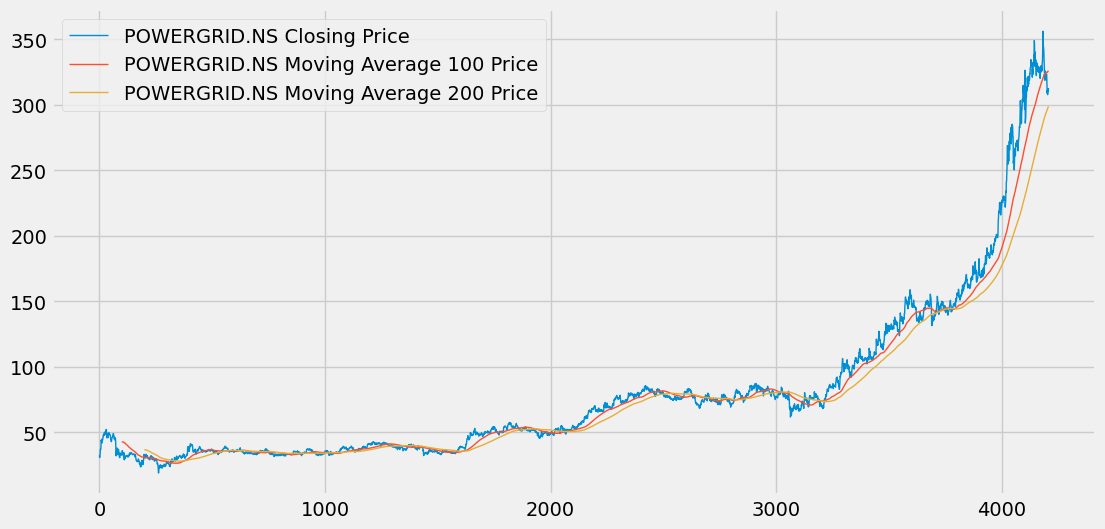

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.Close, label=f'{stock} Closing Price', linewidth= 1)
plt.plot(ma100,label= f'{stock} Moving Average 100 Price', linewidth= 1)
plt.plot(ma200,label= f'{stock} Moving Average 200 Price', linewidth= 1)
plt.legend()
plt.show()#This creates a plot that shows:

#Stock's Closing Price over time

#100-period Moving Average (to capture short-term trends)

#200-period Moving Average (for long-term trend smoothing)

#The legend differentiates the lines on the plot, and the chart helps you compare the stock‚Äôs price with its moving averages, showing where trends may shift.

In [ ]:
ema100=df.Close.ewm(span=100,adjust=False).mean()
#This line computes the 100-period Exponential Moving Average (EMA) for the closing prices.

#The ewm() method applies exponential smoothing, giving more weight to recent values.

#The span=100 means it considers the previous 100 periods, and adjust=False means it applies the weighting directly to the data without adjusting for bias at the start.

#The EMA will be more responsive to recent price movements than the simple moving average (SMA), making it useful for spotting trends faster.


In [ ]:
ema200=df['Close'].ewm(span=200, adjust=False).mean()
#This line computes the 200-period Exponential Moving Average (EMA) for the closing prices.

#Like the previous EMA, it gives more weight to recent prices, but over a longer period (200 periods), helping you identify long-term trends more clearly.

#You now have both EMA100 and EMA200, which can be used to analyze short-term vs. long-term trends.

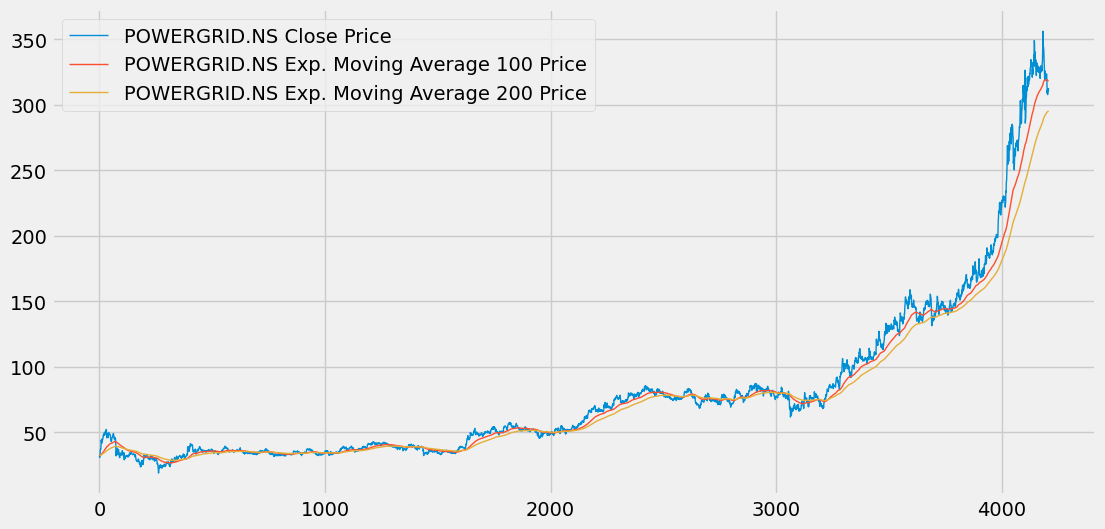

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.Close, label=f'{stock} Close Price', linewidth= 1)
plt.plot(ema100,label= f'{stock} Exp. Moving Average 100 Price', linewidth= 1)
plt.plot(ema200,label= f'{stock} Exp. Moving Average 200 Price', linewidth= 1)
plt.legend()
plt.show()

In [ ]:
#Training and Testing
data_training = pd.DataFrame(df['Close'][0:int(len(df) * 0.70)])  # Create the training dataset (first 70% of the 'Close' column data)
data_testing = pd.DataFrame(df['Close'][int(len(df) * 0.70):int(len(df))])  # Create the testing dataset (remaining 30% of the 'Close' column data)


This splits your dataset into training and testing sets:

Training set: The first 70% of the data (used to train the model).

Testing set: The remaining 30% of the data (used to evaluate the model's performance).

This train-test split is crucial for validating machine learning models, ensuring they don't overfit to the data.

In [ ]:
data_training.shape

(2945, 1)

In [ ]:
data_testing.shape

(1263, 1)

In [ ]:
#scaling
scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize the MinMaxScaler to scale data values between 0 and 1



MinMaxScaler scales the data so that all values lie within the range (0, 1). This is important for algorithms like LSTM, as they perform better when the data is normalized.

The feature_range=(0, 1) ensures that all the values of the input data are transformed within this range.

In [ ]:
data_training_array = scaler.fit_transform(data_training)  # Scale the training data (Close prices) to a range of 0 to 1 using the MinMaxScaler


The fit_transform() method fits the MinMaxScaler to the training data and scales it to the range (0, 1).

The result is stored in data_training_array, which is now ready for training models like LSTM.

In [ ]:
data_training_array

array([[0.19808599],
       [0.17371825],
       [0.2044738 ],
       ...,
       [0.90774421],
       [0.86000357],
       [0.87299622]])

In [ ]:
data_training_array.shape[0]

2945

In [ ]:
x_train = []  # Initialize an empty list to store the features for training
y_train = []  # Initialize an empty list to store the target values for training

for i in range(100, data_training_array.shape[0]):  # Loop through the training data starting from index 100
    x_train.append(data_training_array[i-100:i])  # Append the previous 100 data points as features (input)
    y_train.append(data_training_array[i, 0])  # Append the next data point as the target (output)

x_train, y_train = np.array(x_train), np.array(y_train)  # Convert the feature and target lists into numpy arrays


This prepares the training data for the LSTM model:

x_train: A sequence of the last 100 days' prices used as input features to predict the next day's price.

y_train: The corresponding target values (next day's price).

The data is organized into sequences to train the LSTM model, where each sequence consists of 100 previous days' prices.

In [ ]:
x_train.shape

(2845, 100, 1)

In [ ]:
#Model Building

model = Sequential()  # Initialize the Sequential model (a linear stack of layers)

# Add the first LSTM layer with 50 units, ReLU activation, and return sequences for stacking more LSTM layers
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(Dropout(0.2))  # Add Dropout to prevent overfitting by randomly setting 20% of the input units to zero

# Add the second LSTM layer with 60 units and ReLU activation, returning sequences to maintain dimensionality
model.add(LSTM(units=60, activation='relu', return_sequences=True))

model.add(Dropout(0.3))  # Add Dropout with 30% rate

# Add the third LSTM layer with 80 units and ReLU activation, returning sequences for further layers
model.add(LSTM(units=80, activation='relu', return_sequences=True))

model.add(Dropout(0.4))  # Add Dropout with 40% rate

# Add the fourth LSTM layer with 120 units and ReLU activation, without returning sequences since it's the last LSTM layer
model.add(LSTM(units=120, activation='relu'))

model.add(Dropout(0.5))  # Add Dropout with 50% rate

# Add a Dense layer with a single unit to output the predicted price (regression output)
model.add(Dense(units=1))


#This code defines an LSTM neural network to predict stock prices.

#LSTM layers capture the temporal dependencies in the sequential stock data.

#Dropout layers are added after each LSTM to prevent overfitting by randomly setting a fraction of inputs to zero during training.

#The final Dense layer produces the predicted value (closing price for the next time step).



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1. **LSTM** (Long Short-Term Memory) Layers
What it is: An LSTM is a type of recurrent neural network (RNN). It is particularly good for learning from sequences, such as time series data (like stock prices over time). Unlike regular neural networks, LSTMs can "remember" information from earlier steps in a sequence and use it for predictions.

Temporal dependencies: This means the model is learning from the order of the data. For stock prices, this means the model can predict future prices based on past prices.

2. **ReLU** (Rectified Linear Unit) Activation Function
What it is: ReLU is a mathematical function used to introduce non-linearity into the model. It helps the network learn more complex patterns.

Formula: f(x) = max(0, x)

What it does: If the input is positive, it keeps it; if it's negative, it outputs zero. This makes the model faster and less likely to run into problems like the vanishing gradient.

Why ReLU: It allows the network to learn faster and handle complex patterns, which is especially useful for things like stock prices that change in non-linear ways.

3. **Dropout**
What it is: Dropout is a technique to prevent the model from overfitting. It randomly "drops" (sets to zero) some percentage of the neurons during each training step.

Why it's used: This forces the model to learn more robust features and prevents it from memorizing the data (overfitting). For example, when you add Dropout(0.2), 20% of the neurons will be randomly ignored during training.

4. Dense Layer
**bold text**What it is: A Dense layer is a fully connected layer in the neural network. Each neuron is connected to every other neuron in the previous layer.

For stock prediction: The final Dense layer with a single output neuron (unit = 1) predicts the next stock price based on all the previous learned features.

Putting it all together in simpler terms:
LSTM Layers learn patterns from past stock prices (they "remember" important information).

ReLU Activation helps the model make sense of these patterns and learn faster.

Dropout ensures the model doesn't overfit to the training data (which would make it bad at predicting future data).

The Dense Layer at the end gives the final output ‚Äî in this case, the predicted stock price.

In [ ]:

model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 100, 50)        ‚îÇ        10,400 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 100, 50)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 100, 60)        ‚îÇ        26,640 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 100, 60)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, 100, 80)        ‚îÇ        45,120 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 100, 80)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_3 (LSTM)                   ‚îÇ (None, 120)            ‚îÇ        96,480 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 120)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ           121 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model with the 'adam' optimizer and mean squared error loss function

model.fit(x_train, y_train, epochs=50)  # Train the model on the training data for 50 epochs


Epoch 1/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 99ms/step - loss: 0.0821
Epoch 2/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 37ms/step - loss: 0.0074
Epoch 3/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 36ms/step - loss: 0.0070
Epoch 4/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 35ms/step - loss: 0.0063
Epoch 5/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 35ms/step - loss: 0.0065
Epoch 6/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 36ms/step - loss: 0.0056
Epoch 7/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 35ms/step - loss: 0.0056
Epoch 8/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 36ms/step - loss: 0.0055
Epoch 9/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 36ms/step - loss: 0.0054
Epoch 10/50
89/89 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

model.compile:

Optimizer (adam): Adam is a popular optimizer that adjusts the learning rate during training. It combines the advantages of two other optimizers (AdaGrad and RMSProp) and helps the model learn efficiently.

Loss function (mean_squared_error): This measures the difference between the predicted stock prices and the actual values. The model will try to minimize this error during training. It‚Äôs commonly used for regression problems like predicting stock prices.

model.fit:

Training the model: The model is trained on your x_train (input data) and y_train (target data).

epochs=50: This means the model will iterate through the training data 50 times to improve its predictions. Each epoch is one complete pass through the dataset.

üß† Why this is important:
Training: The model learns the relationship between past stock prices and future prices.

Optimization: The optimizer adjusts the model's parameters to minimize the error (loss).

Loss function: The model's performance is measured by how well it predicts the actual stock prices.

In [ ]:

past_100_days = data_training.tail(100)  # Get the last 100 days of data from the training set to use as input for prediction


This selects the last 100 data points (the most recent 100 closing prices) from the training dataset.

These will be used as input to make predictions about the next stock price.

In [ ]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)  # Concatenate the last 100 days of data with the testing data, reset the index


Combines the data: It merges the last 100 days of training data (past_100_days) with the testing data (data_testing).

ignore_index=True: This ensures that the index is reset after concatenation, so it doesn't carry over any previous indices from the individual datasets.

In [ ]:
final_df.head()

Ticker  POWERGRID.NS
0          76.105652
1          77.657150
2          77.922539
3          77.759224
4          78.208351

In [ ]:

input_data = scaler.fit_transform(final_df)  # Scale the combined data (past 100 days + testing data) to the range (0, 1) using the MinMaxScaler
#This scales the data to a range of 0 to 1 using the MinMaxScaler. It is important to scale the data so the LSTM model can better learn from it.

#This method scales all values (both training and testing data) using the MinMaxScaler, which is often required when working with neural networks like LSTM.

fit():

What it does: It calculates the parameters (e.g., minimum and maximum values for scaling) based on the data.

Use case: This step is used when you want to learn the scaling factors from the data.

transform():

What it does: After calling fit(), transform() uses the learned parameters to scale the data.

Use case: This step is used to apply the learned scaling factors to transform the data, but without recalculating those factors.

fit_transform():

What it does: This method combines the two steps into one. It first fits the scaler to the data (calculates parameters) and then transforms the data using those parameters.



In [ ]:

x_test = []  # Initialize an empty list to store features for testing data
y_test = []  # Initialize an empty list to store target values for testing data

for i in range(100, input_data.shape[0]):  # Loop through the input data starting from index 100
    x_test.append(input_data[i-100:i])  # Append the previous 100 data points as features (input) for prediction
    y_test.append(input_data[i, 0])  # Append the next data point as the target (output) for prediction

x_test, y_test = np.array(x_test), np.array(y_test)  # Convert the feature and target lists into numpy arrays


This prepares the testing data (x_test and y_test) for the prediction phase:

x_test: The previous 100 data points (closing prices) are used to predict the next price (target).

y_test: The actual stock price values (the next day's closing prices) are used as the target to compare with predictions.

In [ ]:

x_test.shape

(1263, 100, 1)

In [ ]:

y_predicted = model.predict(x_test)  # Use the trained model to predict stock prices based on the test data (x_test)


40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 46ms/step


In [ ]:

y_predicted.shape

(1263, 1)

In [ ]:

scaler.scale_  # Access the scaling factor (the range) used by the MinMaxScaler


array([0.00339719])

scaler.scale_: This provides the scaling factor used by the MinMaxScaler during the fitting process. It shows how much the data was scaled in each feature (in this case, the Close prices).

The scale factor is an array where each value corresponds to the scaling factor for a particular feature in the data. For a single feature (like Close price), this will show the scaling factor used to transform the data from its original range to the target range (0 to 1).

In [ ]:
scaler_factor = 1 / 0.0035166  # Calculate the inverse of the scaling factor to reverse the scaling applied earlier
y_predicted = y_predicted * scaler_factor  # Rescale the predicted values back to the original range (before scaling)
y_test = y_test * scaler_factor  # Rescale the actual test values back to the original range (before scaling)


Inverse scaling:

The scaler factor (1 / 0.0035166) is used to reverse the MinMaxScaler transformation and bring the predictions and actual values back to the original price scale.

y_predicted: This contains the model's predicted values, which are rescaled back to their original stock price values.

y_test: The actual test values (stock prices) are also rescaled back to their original values.

By doing this, you can now compare the predicted stock prices with the actual stock prices in their original scale, making the results interpretable in the real-world context.

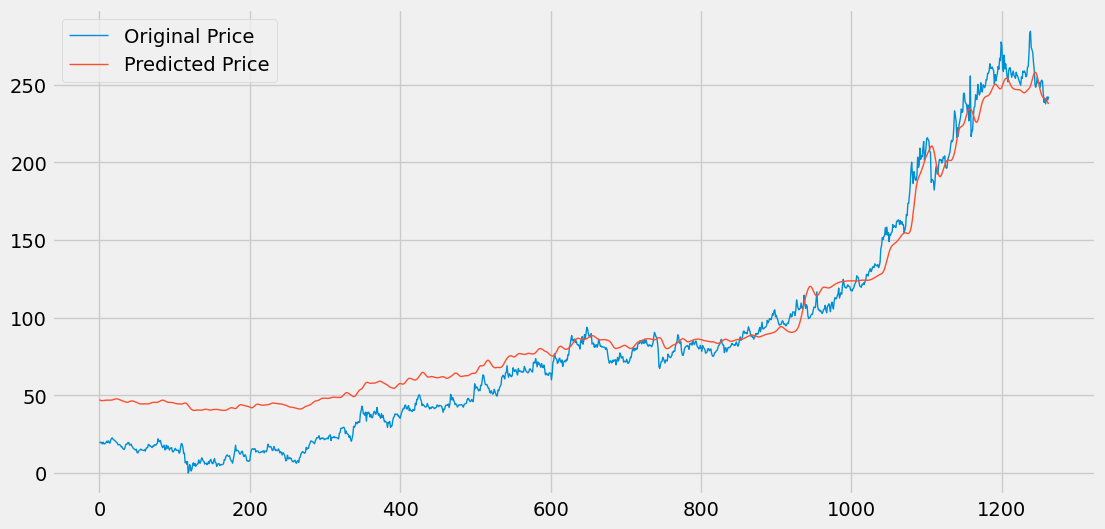

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(y_test, label = 'Original Price', linewidth = 1)
plt.plot(y_predicted, label = 'Predicted Price', linewidth = 1)
plt.legend()
plt.show()

In [ ]:

model.save('stock_dl_model.h5')